# License

Copyright 2019 Navdeep Gill, Patrick Hall, Kim Montgomery, Nick Schmidt

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

**DISCLAIMER**: This notebook is not legal compliance advice.

In [28]:
import h2o
import os
import numpy as np
import math
import shap
import pandas as pd

from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch 

# init h2o
h2o.init(max_mem_size='12G')
h2o.remove_all()

# set random seed for reproducibility
SEED = 22222

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,2 hours 55 mins
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.9
H2O cluster version age:,24 days
H2O cluster name:,H2O_from_python_ngill_vo2rw9
H2O cluster total nodes:,1
H2O cluster free memory:,10.57 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"locked, healthy"


In [2]:
train_path = os.sep.join(['..', 'data', 'output', 'hmda_train.csv'])
train = h2o.import_file(train_path)

test_path = os.sep.join(['..', 'data', 'output', 'hmda_test.csv'])
test = h2o.import_file(test_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [3]:
train.head()

derived_loan_product_type,derived_ethnicity,derived_race,derived_sex,loan_purpose,loan_purpose_desc,reverse_mortgage,reverse_mortgage_desc,loan_amount,loan_to_value_ratio,high_priced,discount_points,lender_credits,loan_term,prepayment_penalty_term,intro_rate_period,negative_amortization,negative_amortization_desc,interest_only_payment,interest_only_payment_desc,balloon_payment,balloon_payment_desc,property_value,income,debt_to_income_ratio,applicant_credit_score_type,applicant_credit_score_type_desc,co_applicant_credit_score_type,co_applicant_credit_score_type_desc,applicant_age,co_applicant_age,applicant_age_above_62,co_applicant_age_above_62,cv_fold
Conventional:First Lien,Not Hispanic or Latino,White,Male,1,Home purchase,2,Not a reverse mortgage,75000,95,0,1068.75,nan,360,nan,nan,2,No negative amortization,2,No interest-only payments,2,No balloon payment,75000,33,36,3,FICO Risk Score Classic 04,10,No co-applicant,25-34,9999,No,,3
Conventional:First Lien,Hispanic or Latino,White,Male,1,Home purchase,2,Not a reverse mortgage,545000,100,0,nan,nan,360,nan,nan,2,No negative amortization,2,No interest-only payments,2,No balloon payment,545000,298,nan,1,Equifax Beacon 5.0,10,No co-applicant,35-44,9999,No,,0
Conventional:First Lien,Ethnicity Not Available,Race Not Available,Male,1,Home purchase,2,Not a reverse mortgage,345000,68.082,0,nan,1735,360,nan,nan,2,No negative amortization,2,No interest-only payments,2,No balloon payment,515000,78,43,3,FICO Risk Score Classic 04,10,No co-applicant,35-44,9999,No,,1
VA:First Lien,Not Hispanic or Latino,White,Male,1,Home purchase,2,Not a reverse mortgage,265000,100,0,2873.67,nan,360,nan,nan,2,No negative amortization,2,No interest-only payments,2,No balloon payment,265000,181,nan,1,Equifax Beacon 5.0,10,No co-applicant,45-54,9999,No,,1
Conventional:First Lien,Not Hispanic or Latino,White,Male,1,Home purchase,2,Not a reverse mortgage,185000,95,0,nan,42.5,360,nan,nan,2,No negative amortization,2,No interest-only payments,2,No balloon payment,195000,194,nan,3,FICO Risk Score Classic 04,9,Not applicable,25-34,nan,No,No,3
Conventional:First Lien,Not Hispanic or Latino,White,Female,1,Home purchase,2,Not a reverse mortgage,105000,95,0,nan,399,360,nan,nan,2,No negative amortization,2,No interest-only payments,2,No balloon payment,115000,79,nan,1,Equifax Beacon 5.0,9,Not applicable,25-34,nan,No,No,3
Conventional:First Lien,Not Hispanic or Latino,White,Joint,1,Home purchase,2,Not a reverse mortgage,315000,60,0,nan,nan,180,nan,nan,2,No negative amortization,2,No interest-only payments,2,No balloon payment,515000,167,nan,1,Equifax Beacon 5.0,2,Experian Fair Isaac,55-64,nan,No,No,4
Conventional:First Lien,Ethnicity Not Available,Race Not Available,Joint,1,Home purchase,2,Not a reverse mortgage,325000,55.036,0,9047.5,nan,360,nan,nan,2,No negative amortization,2,No interest-only payments,2,No balloon payment,595000,90,nan,9,Not applicable,1,Equifax Beacon 5.0,65-74,nan,Yes,Yes,0
Conventional:First Lien,Hispanic or Latino,White,Joint,1,Home purchase,2,Not a reverse mortgage,175000,79.817,0,6567.29,nan,360,nan,nan,2,No negative amortization,2,No interest-only payments,2,No balloon payment,225000,61,nan,1,Equifax Beacon 5.0,1,Equifax Beacon 5.0,35-44,nan,No,No,2
Conventional:First Lien,Ethnicity Not Available,Race Not Available,Sex Not Available,1,Home purchase,2,Not a reverse mortgage,185000,95,1,nan,1389.38,360,nan,nan,2,No negative amortization,2,No interest-only payments,2,No balloon payment,195000,61,49,2,Experian Fair Isaac,9,Not applicable,65-74,nan,Yes,Yes,0


In [4]:
train.summary()

,derived_loan_product_type,derived_ethnicity,derived_race,derived_sex,loan_purpose,loan_purpose_desc,reverse_mortgage,reverse_mortgage_desc,loan_amount,loan_to_value_ratio,high_priced,discount_points,lender_credits,loan_term,prepayment_penalty_term,intro_rate_period,negative_amortization,negative_amortization_desc,interest_only_payment,interest_only_payment_desc,balloon_payment,balloon_payment_desc,property_value,income,debt_to_income_ratio,applicant_credit_score_type,applicant_credit_score_type_desc,co_applicant_credit_score_type,co_applicant_credit_score_type_desc,applicant_age,co_applicant_age,applicant_age_above_62,co_applicant_age_above_62,cv_fold
type,enum,enum,enum,enum,int,enum,int,enum,int,real,int,real,real,int,int,int,int,enum,int,enum,int,enum,int,int,int,int,enum,int,enum,enum,int,enum,enum,int
mins,,,,,1.0,,1.0,,5000.0,0.07,0.0,0.01,0.01,1.0,0.0,1.0,1.0,,1.0,,1.0,,5000.0,-4.0,36.0,1.0,,1.0,,,8888.0,,,0.0
mean,,,,,1.0,,2.2845347222222214,,275712.91666666674,93.63980445093523,0.1093125,1780.7813216567938,952.6263970252761,348.3484510274331,16.09090909090909,93.9097736177623,2.4235277777777764,,2.407701388888889,,2.416208333333334,,366956.4594672014,129.04048188377845,42.4431987050207,3.2556041666666666,,8.367777777777778,,,9996.58974651747,,,2.0004166666666676
maxs,,,,,1.0,,1111.0,,14005000.0,643500.0,1.0,110262.0,99999.99,729.0,54.0,425.0,1111.0,,1111.0,,1111.0,,775005000.0,163000.0,49.0,1111.0,,1111.0,,,9999.0,,,4.0
sigma,,,,,0.0,,17.774496924348146,,233379.4103005898,1777.5534748671541,0.31203197509600816,2308.3904654772614,1767.5166321369227,46.84578614785412,18.069874824567783,58.02179976615468,21.66956734718421,,21.67023606148193,,21.669878055815712,,3043850.7368578054,1461.2876571502493,3.9599927734968032,18.622289468519252,,18.650985293481092,,,51.691548599473755,,,1.4153620911121243
zeros,,,,,0,,0,,0,0,128259,0,0,0,47,0,0,,0,,0,,0,738,0,0,,0,,,0,,,28942
missing,0,0,0,0,0,0,0,0,0,3833,0,101122,89205,195,143912,134812,0,0,0,0,0,0,869,1393,68632,0,0,0,0,0,65178,62,78822,0
0,Conventional:First Lien,Not Hispanic or Latino,White,Male,1.0,Home purchase,2.0,Not a reverse mortgage,75000.0,95.0,0.0,1068.75,nan,360.0,nan,nan,2.0,No negative amortization,2.0,No interest-only payments,2.0,No balloon payment,75000.0,33.0,36.0,3.0,FICO Risk Score Classic 04,10.0,No co-applicant,25-34,9999.0,No,,3.0
1,Conventional:First Lien,Hispanic or Latino,White,Male,1.0,Home purchase,2.0,Not a reverse mortgage,545000.0,100.0,0.0,nan,nan,360.0,nan,nan,2.0,No negative amortization,2.0,No interest-only payments,2.0,No balloon payment,545000.0,298.0,nan,1.0,Equifax Beacon 5.0,10.0,No co-applicant,35-44,9999.0,No,,0.0
2,Conventional:First Lien,Ethnicity Not Available,Race Not Available,Male,1.0,Home purchase,2.0,Not a reverse mortgage,345000.0,68.082,0.0,nan,1735.0,360.0,nan,nan,2.0,No negative amortization,2.0,No interest-only payments,2.0,No balloon payment,515000.0,78.0,43.0,3.0,FICO Risk Score Classic 04,10.0,No co-applicant,35-44,9999.0,No,,1.0


In [5]:
test.head()

derived_loan_product_type,derived_ethnicity,derived_race,derived_sex,loan_purpose,loan_purpose_desc,reverse_mortgage,reverse_mortgage_desc,loan_amount,loan_to_value_ratio,high_priced,discount_points,lender_credits,loan_term,prepayment_penalty_term,intro_rate_period,negative_amortization,negative_amortization_desc,interest_only_payment,interest_only_payment_desc,balloon_payment,balloon_payment_desc,property_value,income,debt_to_income_ratio,applicant_credit_score_type,applicant_credit_score_type_desc,co_applicant_credit_score_type,co_applicant_credit_score_type_desc,applicant_age,co_applicant_age,applicant_age_above_62,co_applicant_age_above_62
VA:First Lien,Not Hispanic or Latino,Black or African American,Sex Not Available,1,Home purchase,2,Not a reverse mortgage,235000,100,0,nan,537.38,360,nan,nan,2,No negative amortization,2,No interest-only payments,2,No balloon payment,235000,68,37,1,Equifax Beacon 5.0,10,No co-applicant,45-54,9999,No,
VA:First Lien,Ethnicity Not Available,Race Not Available,Male,1,Home purchase,2,Not a reverse mortgage,155000,100,0,nan,462.94,360,nan,nan,2,No negative amortization,2,No interest-only payments,2,No balloon payment,155000,45,38,1,Equifax Beacon 5.0,10,No co-applicant,25-34,9999,No,
Conventional:First Lien,Ethnicity Not Available,White,Male,1,Home purchase,2,Not a reverse mortgage,255000,80,0,nan,nan,360,nan,nan,2,No negative amortization,2,No interest-only payments,2,No balloon payment,325000,78,46,2,Experian Fair Isaac,10,No co-applicant,45-54,9999,No,
Conventional:First Lien,Not Hispanic or Latino,White,Joint,1,Home purchase,2,Not a reverse mortgage,355000,95,0,nan,nan,360,nan,nan,2,No negative amortization,2,No interest-only payments,2,No balloon payment,385000,179,nan,1,Equifax Beacon 5.0,9,Not applicable,45-54,nan,No,No
FHA:First Lien,Not Hispanic or Latino,White,Joint,1,Home purchase,2,Not a reverse mortgage,165000,96.5,0,1114.63,nan,360,nan,nan,2,No negative amortization,2,No interest-only payments,2,No balloon payment,175000,102,nan,3,FICO Risk Score Classic 04,9,Not applicable,35-44,nan,No,No
Conventional:First Lien,Not Hispanic or Latino,White,Joint,1,Home purchase,2,Not a reverse mortgage,125000,97,0,nan,750,240,nan,nan,2,No negative amortization,2,No interest-only payments,2,No balloon payment,135000,47,44,3,FICO Risk Score Classic 04,9,Not applicable,25-34,nan,No,No
Conventional:First Lien,Not Hispanic or Latino,White,Joint,1,Home purchase,2,Not a reverse mortgage,145000,85,0,nan,300,360,nan,60,2,No negative amortization,2,No interest-only payments,2,No balloon payment,185000,113,nan,8,Other credit scoring model,8,Other credit scoring model,25-34,nan,No,No
Conventional:First Lien,Not Hispanic or Latino,Asian,Female,1,Home purchase,2,Not a reverse mortgage,685000,75,0,nan,nan,360,nan,84,2,No negative amortization,2,No interest-only payments,2,No balloon payment,915000,220,nan,2,Experian Fair Isaac,10,No co-applicant,25-34,9999,No,
VA:First Lien,Not Hispanic or Latino,White,Male,1,Home purchase,2,Not a reverse mortgage,205000,100,0,nan,1057.04,360,nan,nan,2,No negative amortization,2,No interest-only payments,2,No balloon payment,205000,46,42,3,FICO Risk Score Classic 04,10,No co-applicant,35-44,9999,No,
Conventional:First Lien,Not Hispanic or Latino,White,Male,1,Home purchase,2,Not a reverse mortgage,65000,95,0,nan,350,360,nan,nan,2,No negative amortization,2,No interest-only payments,2,No balloon payment,nan,67,nan,9,Not applicable,10,No co-applicant,45-54,9999,No,


In [6]:
test.summary()

,derived_loan_product_type,derived_ethnicity,derived_race,derived_sex,loan_purpose,loan_purpose_desc,reverse_mortgage,reverse_mortgage_desc,loan_amount,loan_to_value_ratio,high_priced,discount_points,lender_credits,loan_term,prepayment_penalty_term,intro_rate_period,negative_amortization,negative_amortization_desc,interest_only_payment,interest_only_payment_desc,balloon_payment,balloon_payment_desc,property_value,income,debt_to_income_ratio,applicant_credit_score_type,applicant_credit_score_type_desc,co_applicant_credit_score_type,co_applicant_credit_score_type_desc,applicant_age,co_applicant_age,applicant_age_above_62,co_applicant_age_above_62
type,enum,enum,enum,enum,int,enum,int,enum,int,real,int,real,real,int,int,int,int,enum,int,enum,int,enum,int,int,int,int,enum,int,enum,enum,int,enum,enum
mins,,,,,1.0,,1.0,,5000.0,1.0,0.0,0.01,0.01,6.0,0.0,1.0,1.0,,1.0,,1.0,,5000.0,0.0,36.0,1.0,,1.0,,,8888.0,,
mean,,,,,1.0,,2.3386388888888887,,276516.6666666667,89.69511914493116,0.10875,1757.3937057039986,958.7801254896272,348.46688170847,21.75,93.46895640686922,2.3696388888888893,,2.3532777777777776,,2.3613333333333335,,350258.2907272372,129.19422483880012,42.46012464349845,3.359722222222223,,8.502444444444444,,,9996.926506935684,,
maxs,,,,,1.0,,1111.0,,9705000.0,101446.0,1.0,68400.0,55459.0,480.0,54.0,360.0,1111.0,,1111.0,,1111.0,,144005000.0,179000.0,49.0,1111.0,,1111.0,,,9999.0,,
sigma,,,,,0.0,,19.38280047007571,,232690.83775031558,542.0284475439462,0.31132961615062743,2295.349372497006,1774.6607391132238,46.70574574957731,18.45617606067434,58.69896906923912,20.244384715560336,,20.245080936505943,,20.244739800672498,,864710.201510732,1569.0416971291431,3.9418031374119744,21.97870854868645,,21.974950817384173,,,47.95276226904456,,
zeros,,,,,0,,0,,0,0,32085,0,0,0,9,0,0,,0,,0,,0,167,0,0,,0,,,0,,
missing,0,0,0,0,0,0,0,0,0,1001,0,25446,22214,38,35976,33729,0,0,0,0,0,0,207,330,17066,0,0,0,0,0,16175,15,19825
0,VA:First Lien,Not Hispanic or Latino,Black or African American,Sex Not Available,1.0,Home purchase,2.0,Not a reverse mortgage,235000.0,100.0,0.0,nan,537.38,360.0,nan,nan,2.0,No negative amortization,2.0,No interest-only payments,2.0,No balloon payment,235000.0,68.0,37.0,1.0,Equifax Beacon 5.0,10.0,No co-applicant,45-54,9999.0,No,
1,VA:First Lien,Ethnicity Not Available,Race Not Available,Male,1.0,Home purchase,2.0,Not a reverse mortgage,155000.0,100.0,0.0,nan,462.94,360.0,nan,nan,2.0,No negative amortization,2.0,No interest-only payments,2.0,No balloon payment,155000.0,45.0,38.0,1.0,Equifax Beacon 5.0,10.0,No co-applicant,25-34,9999.0,No,
2,Conventional:First Lien,Ethnicity Not Available,White,Male,1.0,Home purchase,2.0,Not a reverse mortgage,255000.0,80.0,0.0,nan,nan,360.0,nan,nan,2.0,No negative amortization,2.0,No interest-only payments,2.0,No balloon payment,325000.0,78.0,46.0,2.0,Experian Fair Isaac,10.0,No co-applicant,45-54,9999.0,No,


In [7]:
# Inputs and output
X = ['derived_loan_product_type', 
     'loan_purpose_desc',  
     'reverse_mortgage_desc', 
     'loan_amount', 
     'loan_to_value_ratio', 
     'discount_points', 
     'lender_credits', 
     'loan_term', 
     'prepayment_penalty_term', 
     'intro_rate_period',  
     'negative_amortization_desc',  
     'interest_only_payment_desc', 
     'balloon_payment_desc', 
     'property_value', 
     'income', 
     'debt_to_income_ratio', 
     'applicant_credit_score_type_desc', 
     'co_applicant_credit_score_type_desc']
fold_column = 'cv_fold'
Y = "high_priced"

In [8]:
# Convert outcome to categorical
train[Y] = train[Y].asfactor()
test[Y] = test[Y].asfactor()

In [9]:
# Create Pandas frame for correlation purposes
train_pd_for_corr = train.as_data_frame()

In [10]:
# Get correlation
numeric_corr = pd.DataFrame(train_pd_for_corr[X + [Y]].corr()[Y]).iloc[:-1]
numeric_corr

,high_priced
loan_amount,-0.122799
loan_to_value_ratio,0.001567
discount_points,-0.028771
lender_credits,0.004091
loan_term,-0.003213
prepayment_penalty_term,0.059624
intro_rate_period,-0.051503
property_value,-0.016780
income,-0.010434
debt_to_income_ratio,0.033009


In [11]:
# Apply monotonicity constraints
mono_constraints = tuple([int(i) for i in np.sign(train_pd_for_corr[X + [Y]].corr()[Y].values[:-1])])
mono_constraints = dict(zip(list(numeric_corr.index.tolist()), mono_constraints))
mono_constraints

{'loan_amount': -1,
 'loan_to_value_ratio': 1,
 'discount_points': -1,
 'lender_credits': 1,
 'loan_term': -1,
 'prepayment_penalty_term': 1,
 'intro_rate_period': -1,
 'property_value': -1,
 'income': -1,
 'debt_to_income_ratio': 1}

In [12]:
# Default GBM
mgbm_default = H2OGradientBoostingEstimator(
               # monotonicity constraints
               monotone_constraints=mono_constraints, 
               seed=SEED)
mgbm_default.train(x=X,
              y=Y,
              training_frame=train,
              fold_column=fold_column)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [13]:
mgbm_default

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1574453305437_4529


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,17949.0,5.0,5.0,5.0,13.0,32.0,24.14




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.07557949488520277
RMSE: 0.274917250977822
LogLoss: 0.253685576437749
Mean Per-Class Error: 0.20607804014132336
AUC: 0.8540561037079359
pr_auc: 0.4247581792003528
Gini: 0.7081122074158719

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.27749136491807896: 


,,0,1,Error,Rate
0,0,112493.0,15766.0,0.1229,(15766.0/128259.0)
1,1,5281.0,10460.0,0.3355,(5281.0/15741.0)
2,Total,117774.0,26226.0,0.1462,(21047.0/144000.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.277491,0.498487,193.0
1,max f2,0.102179,0.616222,276.0
2,max f0point5,0.358217,0.453223,142.0
3,max accuracy,0.494021,0.894167,65.0
4,max precision,0.908298,1.000000,0.0
5,max recall,0.005253,1.000000,399.0
6,max specificity,0.908298,1.000000,0.0
7,max absolute_mcc,0.204478,0.439956,228.0
8,max min_per_class_accuracy,0.077817,0.787307,292.0
9,max mean_per_class_accuracy,0.102179,0.793922,276.0



Gains/Lift Table: Avg response rate: 10.93 %, avg score: 10.92 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010563,0.526539,5.671692,5.671692,0.619987,0.580225,0.619987,0.580225,0.059907,0.059907,467.169217,467.169217
1,,2,0.020118,0.484979,4.946348,5.327173,0.540698,0.504627,0.582327,0.544318,0.047265,0.107172,394.634808,432.717251
2,,3,0.030000,0.447139,4.467968,5.044152,0.488405,0.464739,0.551389,0.518105,0.044152,0.151325,346.796824,404.415221
3,,4,0.040111,0.429487,4.134231,4.814781,0.451923,0.437605,0.526316,0.497812,0.041802,0.193126,313.423055,381.478138
4,,5,0.050000,0.421272,4.034408,4.660441,0.441011,0.425632,0.509444,0.483537,0.039896,0.233022,303.440810,366.044089
5,,6,0.100007,0.374918,3.722245,4.191310,0.406888,0.401868,0.458163,0.442700,0.186138,0.419160,272.224523,319.131049
6,,7,0.150000,0.314126,3.244209,3.875654,0.354633,0.342774,0.423657,0.409396,0.162188,0.581348,224.420892,287.565381
7,,8,0.200000,0.224021,2.383584,3.502636,0.260556,0.279988,0.382882,0.377044,0.119179,0.700527,138.358427,250.263643
8,,9,0.300514,0.066445,1.094686,2.697241,0.119663,0.108950,0.294842,0.287373,0.110031,0.810558,9.468582,169.724111
9,,10,0.401792,0.054373,0.565796,2.159978,0.061849,0.059842,0.236113,0.230021,0.057303,0.867861,-43.420376,115.997760




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.07592703362772245
RMSE: 0.275548604837191
LogLoss: 0.25348279955772096
Mean Per-Class Error: 0.20385662469501664
AUC: 0.8572238123927975
pr_auc: 0.4148513595555996
Gini: 0.7144476247855951

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.27448005622185173: 


,,0,1,Error,Rate
0,0,112578.0,15681.0,0.1223,(15681.0/128259.0)
1,1,5410.0,10331.0,0.3437,(5410.0/15741.0)
2,Total,117988.0,26012.0,0.1465,(21091.0/144000.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.274480,0.494863,193.0
1,max f2,0.087775,0.617852,285.0
2,max f0point5,0.349337,0.446576,146.0
3,max accuracy,0.477377,0.893049,71.0
4,max precision,0.920926,1.000000,0.0
5,max recall,0.004978,1.000000,399.0
6,max specificity,0.920926,1.000000,0.0
7,max absolute_mcc,0.227861,0.436405,215.0
8,max min_per_class_accuracy,0.080042,0.794041,291.0
9,max mean_per_class_accuracy,0.087775,0.796143,285.0



Gains/Lift Table: Avg response rate: 10.93 %, avg score: 10.89 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010035,0.531685,5.387557,5.387557,0.588927,0.585222,0.588927,0.585222,0.054063,0.054063,438.755710,438.755710
1,,2,0.020000,0.488478,4.749354,5.069564,0.519164,0.508201,0.554167,0.546845,0.047329,0.101391,374.935404,406.956356
2,,3,0.030042,0.453087,4.409554,4.848950,0.482019,0.469362,0.530051,0.520946,0.044279,0.145671,340.955393,384.895008
3,,4,0.040014,0.434095,4.102623,4.662951,0.448468,0.442570,0.509719,0.501413,0.040912,0.186583,310.262291,366.295115
4,,5,0.050000,0.423766,3.912428,4.513055,0.427677,0.428585,0.493333,0.486868,0.039070,0.225653,291.242840,351.305508
5,,6,0.100000,0.375771,3.762150,4.137602,0.411250,0.402755,0.452292,0.444811,0.188107,0.413760,276.214980,313.760244
6,,7,0.150000,0.313294,3.246299,3.840501,0.354861,0.342579,0.419815,0.410734,0.162315,0.576075,224.629947,284.050145
7,,8,0.200000,0.218791,2.434407,3.488978,0.266111,0.276526,0.381389,0.377182,0.121720,0.697796,143.440696,248.897783
8,,9,0.300021,0.068661,1.207423,2.728354,0.131986,0.110296,0.298243,0.288208,0.120767,0.818563,20.742268,172.835383
9,,10,0.400639,0.053590,0.597287,2.193149,0.065291,0.059886,0.239739,0.230866,0.060098,0.878661,-40.271323,119.314911




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.8522794,0.0047718654,0.8448967,0.85435534,0.855331,0.8502122,0.85660183
1,auc,0.8571786,0.011797692,0.8492658,0.8484984,0.8514252,0.87659806,0.86010563
2,err,0.14772059,0.0047718654,0.15510331,0.14564465,0.144669,0.1497878,0.1433982
3,err_count,4254.8,155.92049,4489.0,4165.0,4152.0,4341.0,4127.0
4,f0point5,0.43072483,0.009695721,0.42491448,0.43752867,0.442928,0.41865006,0.4296029
5,f1,0.4963272,0.0062232506,0.49624062,0.501973,0.50168025,0.4866974,0.49504465
6,f2,0.5857184,0.007051395,0.5963426,0.58868074,0.57840264,0.58115894,0.5840069
7,lift_top_group,5.362649,0.34830162,5.100405,5.29263,5.146379,5.9643025,5.309528
8,logloss,0.2535012,0.007921472,0.2583097,0.25776643,0.2613442,0.24344827,0.24663743
9,max_per_class_error,0.3341223,0.015961256,0.31100032,0.3347068,0.3559322,0.33246836,0.33650377



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2019-11-22 14:52:11,17.518 sec,0.0,0.312031,0.345076,0.500000,0.000000,1.000000,0.890687
1,,2019-11-22 14:52:11,17.577 sec,1.0,0.305509,0.326049,0.830789,0.384124,4.269835,0.163625
2,,2019-11-22 14:52:11,17.629 sec,2.0,0.300002,0.312157,0.840504,0.403765,5.061196,0.154111
3,,2019-11-22 14:52:11,17.686 sec,3.0,0.295614,0.301983,0.841525,0.405699,5.104669,0.152042
4,,2019-11-22 14:52:11,17.740 sec,4.0,0.292071,0.294159,0.844356,0.406811,5.306426,0.151896
5,,2019-11-22 14:52:11,17.797 sec,5.0,0.289217,0.287953,0.846359,0.408450,5.342610,0.151819
6,,2019-11-22 14:52:11,17.855 sec,6.0,0.286897,0.282933,0.846517,0.408212,5.342653,0.151667
7,,2019-11-22 14:52:11,17.915 sec,7.0,0.284957,0.278724,0.847956,0.409203,5.342610,0.149576
8,,2019-11-22 14:52:11,17.978 sec,8.0,0.283406,0.275312,0.849575,0.409958,5.385697,0.149639
9,,2019-11-22 14:52:11,18.042 sec,9.0,0.282142,0.272451,0.849874,0.409798,5.385081,0.153708



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,derived_loan_product_type,13330.988281,1.000000,0.829040
1,loan_amount,1160.186523,0.087029,0.072151
2,loan_term,388.783234,0.029164,0.024178
3,intro_rate_period,237.202347,0.017793,0.014751
4,loan_to_value_ratio,138.591492,0.010396,0.008619
5,applicant_credit_score_type_desc,128.352600,0.009628,0.007982
6,co_applicant_credit_score_type_desc,126.708778,0.009505,0.007880
7,lender_credits,109.374626,0.008205,0.006802
8,balloon_payment_desc,101.777122,0.007635,0.006329
9,discount_points,87.599419,0.006571,0.005448


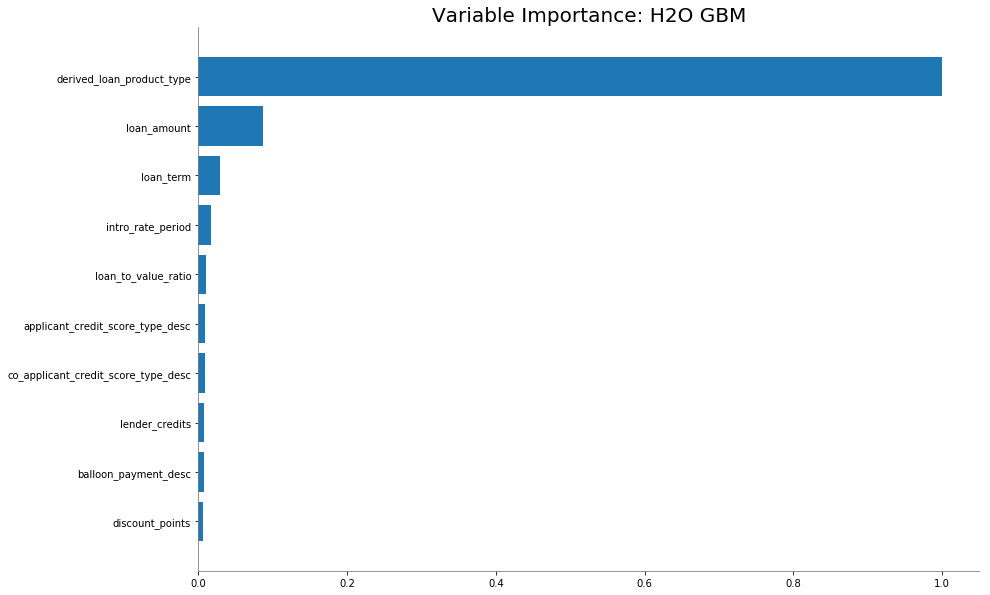

In [14]:
mgbm_default.varimp_plot()

In [15]:
# Function to get Shapley contribs
def get_shapley(model, train, X):
    # calculate SHAP values using function predict_contributions
    contributions = model.predict_contributions(train[X])
    print("First 5 rows of contributions:\n")
    print(contributions.head(5))
    # convert the H2O Frame to use with shap's visualization functions
    contributions_matrix = contributions.as_data_frame().as_matrix()
    # shap values are calculated for all features
    shap_values = contributions_matrix[:,0:len(X)]
    # expected values is the last returned column
    expected_value = contributions_matrix[:,len(X)-1].min()
    return shap_values, expected_value

In [16]:
shap_values_mgbm_default, expected_value_mgbm_default = get_shapley(mgbm_default, train, X)

First 5 rows of contributions:



derived_loan_product_type,reverse_mortgage_desc,loan_amount,loan_to_value_ratio,discount_points,lender_credits,loan_term,prepayment_penalty_term,intro_rate_period,negative_amortization_desc,interest_only_payment_desc,balloon_payment_desc,property_value,income,debt_to_income_ratio,applicant_credit_score_type_desc,co_applicant_credit_score_type_desc,BiasTerm
-0.416984,0.00039652,0.780771,-0.000204023,0.0244321,0.0104061,-0.0100834,0,-0.0258788,2.76569e-07,0.00044795,-0.00344333,0.0100699,0.00904662,-0.0312118,-0.0281481,0.000671009,-2.80387
-0.379709,0.000390639,-0.80842,0.00115162,-0.007922,0.0252241,-0.00989521,0,-0.0273525,2.76569e-07,0.00103383,-0.00149342,-0.0116888,-0.0152658,-0.0360637,-0.011163,0.0273785,-2.80387
-0.347967,0.000393598,-0.231589,-0.00503853,-0.00920427,-0.0235873,-0.0104603,0,-0.0242418,2.76569e-07,0.000575028,-0.00100454,-0.0112865,0.0147576,0.0415342,-0.0206618,0.013906,-2.80387
-1.597,0.0003635,-0.158293,0.00223051,0.0853967,0.0216925,-0.0102432,0,-0.0358156,1.26677e-06,0.000348011,-0.00110552,-0.00330451,-0.0138638,-0.048525,-0.0128282,0.010742,-2.80387
-0.343588,0.000395873,0.196842,0.000350985,-0.00954856,-0.0639275,-0.00967169,0,-0.0173922,2.76569e-07,0.00035528,-0.000523547,0.00495361,-0.0196304,-0.0359247,-0.0209503,-0.0553484,-2.80387


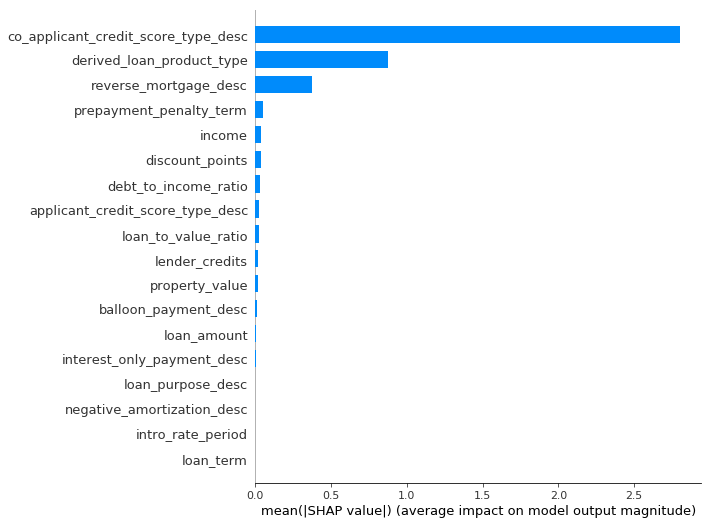

In [17]:
shap.summary_plot(shap_values_mgbm_default, X, plot_type="bar")

In [19]:
## Get the AUC on the test set
perf_mgbm_default = mgbm_default.model_performance(test)
print(perf_mgbm_default.auc())

0.8489230414661247


In [20]:
## Get the AUC on the test set
perf_cv_mgbm_default = mgbm_default.model_performance(xval=True)
print(perf_cv_mgbm_default.auc())

0.8572238123927975


In [21]:
mgbm_lucky = H2OGradientBoostingEstimator(
  # monotonicity constraints
  monotone_constraints=mono_constraints,
    
  # more trees is better if the learning rate is small enough 
  # here, use "more than enough" trees - we have early stopping
  ntrees = 10000,                                                            

  # smaller learning rate is better (this is a good value for most datasets, but see below for annealing)
  learn_rate = 0.01,                                                         

  # early stopping once the validation AUC doesn't improve by at least 0.01% for 5 consecutive scoring events
  stopping_rounds = 5, stopping_tolerance = 1e-4, stopping_metric = "AUC", 

  # sample 80% of rows per tree
  sample_rate = 0.8,                                                       

  # sample 80% of columns per split
  col_sample_rate = 0.8,                                                   

  # fix a random number generator seed for reproducibility
  seed = SEED,                                                             

  # score every 10 trees to make early stopping reproducible (it depends on the scoring interval)
  score_tree_interval = 10)

mgbm_lucky.train(x=X, y=Y, training_frame=train, fold_column=fold_column)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [22]:
mgbm_lucky

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1574453305437_4906


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,274.0,274.0,97305.0,5.0,5.0,5.0,12.0,31.0,23.791971




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.07599340043483153
RMSE: 0.2756690052124677
LogLoss: 0.25500633460356775
Mean Per-Class Error: 0.2026413677645038
AUC: 0.8629760599829418
pr_auc: 0.4247419046605837
Gini: 0.7259521199658836

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2533575368438154: 


,,0,1,Error,Rate
0,0,112359.0,15900.0,0.124,(15900.0/128259.0)
1,1,5293.0,10448.0,0.3363,(5293.0/15741.0)
2,Total,117652.0,26348.0,0.1472,(21193.0/144000.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.253358,0.496472,194.0
1,max f2,0.083174,0.619291,285.0
2,max f0point5,0.306199,0.448206,156.0
3,max accuracy,0.432507,0.893785,70.0
4,max precision,0.713893,0.956522,5.0
5,max recall,0.016865,1.000000,395.0
6,max specificity,0.802453,0.999992,0.0
7,max absolute_mcc,0.209661,0.437851,217.0
8,max min_per_class_accuracy,0.077528,0.796074,291.0
9,max mean_per_class_accuracy,0.082178,0.797359,286.0



Gains/Lift Table: Avg response rate: 10.93 %, avg score: 10.84 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010000,0.487973,5.666730,5.666730,0.619444,0.530744,0.619444,0.530744,0.056667,0.056667,466.673020,466.673020
1,,2,0.020000,0.450368,4.720158,5.193444,0.515972,0.469716,0.567708,0.500230,0.047202,0.103869,372.015755,419.344387
2,,3,0.030000,0.417721,4.599454,4.995447,0.502778,0.431080,0.546065,0.477180,0.045995,0.149863,359.945366,399.544713
3,,4,0.040000,0.405910,4.167461,4.788451,0.455556,0.411642,0.523438,0.460795,0.041675,0.191538,316.746077,378.845054
4,,5,0.050000,0.398869,3.964170,4.623594,0.433333,0.401880,0.505417,0.449012,0.039642,0.231180,296.417000,362.359443
5,,6,0.100000,0.353571,3.678292,4.150943,0.402083,0.379923,0.453750,0.414468,0.183915,0.415094,267.829236,315.094340
6,,7,0.150083,0.290076,3.245972,3.848951,0.354825,0.315580,0.420738,0.381468,0.162569,0.577663,224.597179,284.895121
7,,8,0.200000,0.206871,2.446107,3.498825,0.267390,0.260490,0.382465,0.351274,0.122102,0.699765,144.610721,249.882473
8,,9,0.300000,0.070283,1.268661,2.755437,0.138681,0.104749,0.301204,0.269099,0.126866,0.826631,26.866146,175.543697
9,,10,0.400000,0.057081,0.637190,2.225875,0.069653,0.062987,0.243316,0.217571,0.063719,0.890350,-36.281049,122.587510




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.07782273543479745
RMSE: 0.27896726588400556
LogLoss: 0.2618844814384218
Mean Per-Class Error: 0.20415084960373409
AUC: 0.8488772325663687
pr_auc: 0.3972820283270426
Gini: 0.6977544651327374

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20549433726688632: 


,,0,1,Error,Rate
0,0,111420.0,16839.0,0.1313,(16839.0/128259.0)
1,1,5135.0,10606.0,0.3262,(5135.0/15741.0)
2,Total,116555.0,27445.0,0.1526,(21974.0/144000.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.205494,0.491178,207.0
1,max f2,0.093306,0.618160,270.0
2,max f0point5,0.287690,0.435573,154.0
3,max accuracy,0.463453,0.892250,56.0
4,max precision,0.694292,0.772727,6.0
5,max recall,0.009897,1.000000,396.0
6,max specificity,0.826151,0.999992,0.0
7,max absolute_mcc,0.165762,0.434293,229.0
8,max min_per_class_accuracy,0.086772,0.794931,277.0
9,max mean_per_class_accuracy,0.093306,0.795849,270.0



Gains/Lift Table: Avg response rate: 10.93 %, avg score: 10.88 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010000,0.487906,5.158503,5.158503,0.563889,0.538708,0.563889,0.538708,0.051585,0.051585,415.850327,415.850327
1,,2,0.020000,0.437361,4.491455,4.824979,0.490972,0.460385,0.527431,0.499546,0.044915,0.096500,349.145543,382.497935
2,,3,0.030000,0.418127,4.021346,4.557101,0.439583,0.427193,0.498148,0.475428,0.040213,0.136713,302.134553,355.710141
3,,4,0.040000,0.404701,3.754526,4.356458,0.410417,0.411112,0.476215,0.459349,0.037545,0.174258,275.452640,335.645766
4,,5,0.050000,0.391131,3.741821,4.233530,0.409028,0.397845,0.462778,0.447048,0.037418,0.211677,274.182072,323.353027
5,,6,0.100000,0.302201,3.659234,3.946382,0.400000,0.342178,0.431389,0.394613,0.182962,0.394638,265.923385,294.638206
6,,7,0.150000,0.263561,3.365733,3.752832,0.367917,0.285415,0.410231,0.358214,0.168287,0.562925,236.573280,275.283231
7,,8,0.200000,0.187309,2.626263,3.471190,0.287083,0.223352,0.379444,0.324498,0.131313,0.694238,162.626263,247.118989
8,,9,0.300000,0.082224,1.266756,2.736378,0.138472,0.107653,0.299120,0.252216,0.126676,0.820914,26.675561,173.637846
9,,10,0.400000,0.068884,0.480910,2.172511,0.052569,0.076089,0.237483,0.208184,0.048091,0.869005,-51.909027,117.251128




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.8541053,0.007294057,0.84911203,0.8565584,0.84400696,0.8605293,0.8603197
1,auc,0.86047375,0.010542487,0.8512689,0.85780865,0.8504132,0.87379,0.86908805
2,err,0.14589474,0.007294057,0.15088798,0.14344162,0.15599303,0.13947068,0.13968034
3,err_count,4201.6,207.10698,4367.0,4102.0,4477.0,4042.0,4020.0
4,f0point5,0.43273765,0.004379731,0.4284167,0.4393583,0.4292339,0.43255752,0.43412185
5,f1,0.49608526,0.004243929,0.49450168,0.50036544,0.5001675,0.49029005,0.49510172
6,f2,0.5813492,0.012242227,0.5846929,0.5810467,0.59918684,0.5658071,0.5760126
7,lift_top_group,5.4236183,0.3163957,5.1537194,5.2609377,5.331279,5.9643025,5.407852
8,logloss,0.26189408,0.01736939,0.27806392,0.25656155,0.28245035,0.24531916,0.24707536
9,max_per_class_error,0.3432106,0.022522798,0.33437207,0.34896988,0.30970725,0.36944535,0.35355854



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2019-11-22 14:59:55,1 min 8.950 sec,0.0,0.312031,0.345076,0.500000,0.000000,1.000000,0.890687
1,,2019-11-22 14:59:55,1 min 9.335 sec,10.0,0.306419,0.328401,0.855961,0.407965,5.388042,0.162618
2,,2019-11-22 14:59:56,1 min 9.759 sec,20.0,0.302392,0.317758,0.854518,0.410171,5.377118,0.151681
3,,2019-11-22 14:59:56,1 min 10.183 sec,30.0,0.298110,0.307279,0.855417,0.411990,5.389715,0.156472
4,,2019-11-22 14:59:57,1 min 10.612 sec,40.0,0.294932,0.299934,0.855231,0.411921,5.435818,0.156028
5,,2019-11-22 14:59:57,1 min 11.027 sec,50.0,0.291948,0.293299,0.855684,0.412591,5.457087,0.156819
6,,2019-11-22 14:59:58,1 min 11.467 sec,60.0,0.290082,0.289261,0.854606,0.413156,5.465996,0.157736
7,,2019-11-22 14:59:58,1 min 11.914 sec,70.0,0.288219,0.285124,0.855245,0.414301,5.482498,0.157250
8,,2019-11-22 14:59:58,1 min 12.325 sec,80.0,0.286119,0.280499,0.858025,0.415984,5.514174,0.157375
9,,2019-11-22 14:59:59,1 min 12.759 sec,90.0,0.284499,0.276957,0.858807,0.416746,5.502376,0.155875



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,derived_loan_product_type,123593.695312,1.000000,0.844568
1,loan_amount,9140.473633,0.073956,0.062461
2,loan_term,3159.608643,0.025564,0.021591
3,loan_to_value_ratio,2451.770996,0.019837,0.016754
4,intro_rate_period,1733.875977,0.014029,0.011848
5,property_value,1057.790039,0.008559,0.007228
6,co_applicant_credit_score_type_desc,942.725952,0.007628,0.006442
7,applicant_credit_score_type_desc,773.678772,0.006260,0.005287
8,income,678.189392,0.005487,0.004634
9,balloon_payment_desc,658.406311,0.005327,0.004499


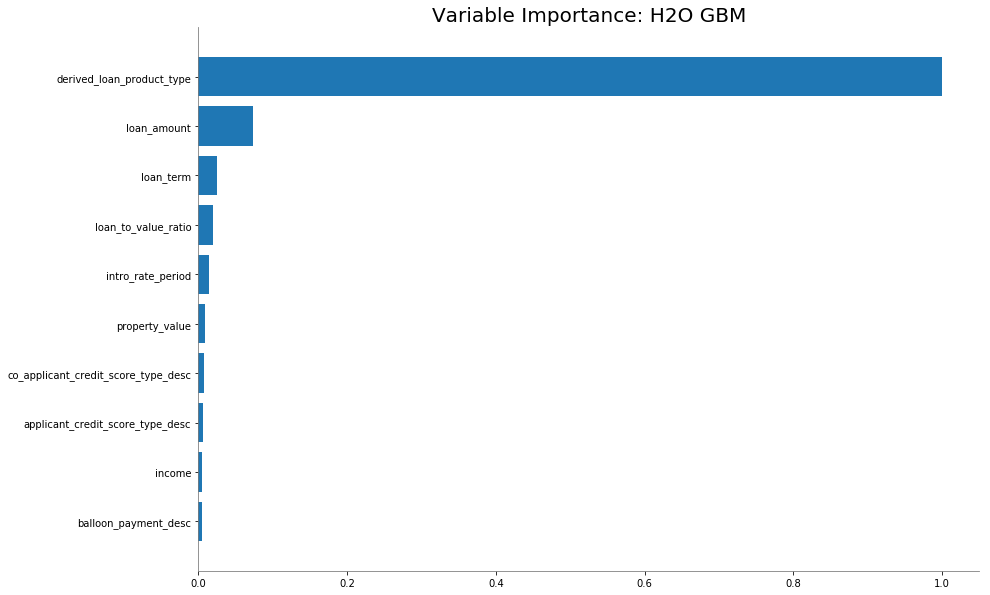

In [23]:
mgbm_lucky.varimp_plot()

In [24]:
shap_values_mgbm_lucky, expected_value_mgbm_lucky = get_shapley(mgbm_lucky, train, X)

First 5 rows of contributions:



derived_loan_product_type,reverse_mortgage_desc,loan_amount,loan_to_value_ratio,discount_points,lender_credits,loan_term,prepayment_penalty_term,intro_rate_period,negative_amortization_desc,interest_only_payment_desc,balloon_payment_desc,property_value,income,debt_to_income_ratio,applicant_credit_score_type_desc,co_applicant_credit_score_type_desc,BiasTerm
-0.34998,0.000849827,0.542689,0.0981133,0.016822,0.00879516,-0.0707497,0,-0.0460475,0,0.000267506,-0.0132818,0.0154963,0.0118604,-0.0427643,-0.0153677,0.00160355,-2.51736
-0.312378,0.000739634,-0.434028,0.094113,-0.00478897,0.0174019,-0.10407,0,-0.0577533,0,0.000923456,-0.0166406,-0.0126421,-0.0337495,-0.0455267,-0.00615087,0.0206777,-2.51736
-0.33488,0.00078858,-0.236734,-0.078585,-0.00426407,-0.01194,-0.111889,0,-0.0572752,0,0.000246769,-0.0170585,-0.0117882,0.0121634,0.0499917,-0.0101275,0.00102067,-2.51736
-1.00434,0.00079626,-0.152908,0.0893508,0.0352156,0.0170717,-0.134094,0,-0.0698222,0,0.000368578,-0.0234394,-0.00592998,-0.0249293,-0.0396111,-0.00487736,0.00177003,-2.51736
-0.321307,0.000809362,0.131027,0.0925918,-0.00552049,-0.0304835,-0.0893929,0,-0.0449981,0,0.000250662,-0.0139556,0.00790889,-0.0476203,-0.0474004,-0.011549,-0.0214545,-2.51736


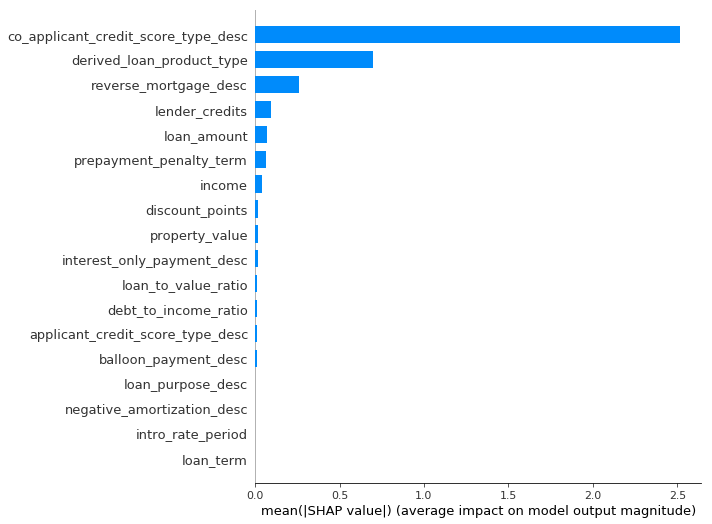

In [25]:
shap.summary_plot(shap_values_mgbm_lucky, X, plot_type="bar")

In [26]:
## Get the AUC on the test set
perf_mgbm_lucky = mgbm_lucky.model_performance(test)
print(perf_mgbm_lucky.auc())

0.8583208873460522


In [27]:
## Get the AUC on the test set
perf_cv_mgbm_lucky = mgbm_lucky.model_performance(xval=True)
print(perf_cv_mgbm_lucky.auc())

0.8488772325663687
